# Bert

In [1]:
import pandas as pd
import glob

import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join

In [2]:
def load(path, pickle_file, ratio=1):
    dataset = pd.read_pickle(path + pickle_file)
    dataset.info(memory_usage='deep')
    if ratio < 1:
        dataset = get_ratio(dataset, ratio)

    return dataset

def loads(data_sets_dir, ratio=1):
    data_sets_files = sorted([f for f in listdir(data_sets_dir) if isfile(join(data_sets_dir, f))])

    if ratio < 1:
        data_sets_files = get_ratio(data_sets_files, ratio)

    dataset = load(data_sets_dir, data_sets_files[0])
    data_sets_files.remove(data_sets_files[0])

    for ds_file in data_sets_files:
        #dataset = dataset.append(load(data_sets_dir, ds_file))
        # 使用 pd.concat 来连接两个 DataFrame
        dataset = pd.concat([dataset, load(data_sets_dir, ds_file)])


    return dataset

In [ ]:
import pandas as pd

def read(path, json_file):
    """
    :param path: str
    :param json_file: str
    :return DataFrame
    """
    return pd.read_json(path + json_file)

def apply_filter(data_frame: pd.DataFrame, filter_func):
    return filter_func(data_frame)

def clean(data_frame: pd.DataFrame):
    return data_frame.drop_duplicates(subset="func", keep=False)

def select(dataset):
    result = dataset.loc[dataset['project'] == "FFmpeg"]
    len_filter = result.func.str.len() < 1200
    result = result.loc[len_filter]
    #print(len(result))
    #result = result.iloc[11001:]
    #print(len(result))
    result = result.head(200)

    return result

def drop(data_frame: pd.DataFrame, keys):
    for key in keys:
        del data_frame[key]

In [4]:
raw = read("dataset/Devign/raw/", "dataset.json")

# filtered = apply_filter(raw, select)
filtered = clean(raw)
drop(filtered, ["commit_id", "project"])

In [5]:
filtered

,target,func
0,0,static av_cold int vdadec_init(AVCodecContext ...
1,0,static int transcode(AVFormatContext **output_...
2,0,"static void v4l2_free_buffer(void *opaque, uin..."
3,0,"int ff_get_wav_header(AVFormatContext *s, AVIO..."
4,0,"int av_opencl_buffer_write(cl_mem dst_cl_buf, ..."
...,...,...
995,0,static inline void RENAME(rgb16to32)(const uin...
996,0,"int ff_xvmc_field_start(MpegEncContext*s, AVCo..."
997,0,"int64_t url_fseek(ByteIOContext *s, int64_t of..."
998,0,"int ff_listen_connect(int fd, const struct soc..."


In [7]:
filtered = filtered.sample(frac=1, random_state=32)
filtered = filtered.reset_index(drop=True)
filtered

,target,func
0,0,static int h264_extradata_to_annexb(AVCodecCon...
1,1,static void blkdebug_refresh_filename(BlockDri...
2,1,static void do_change_vnc(const char *target)\...
3,1,static int vdi_check(BlockDriverState *bs)\n\n...
4,1,static void check_lowpass_line(int depth){\n\n...
...,...,...
995,0,static inline bool migration_bitmap_test_and_r...
996,0,void qdev_prop_set_drive_nofail(DeviceState *d...
997,0,"void mpv_decode_mb_internal(MpegEncContext *s,..."
998,1,"static void mv88w8618_eth_init(NICInfo *nd, ui..."


In [8]:
input_dataset = filtered

In [9]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch
from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizer, BertModel
import torch as th
torch.manual_seed(2020)
import dataclasses
from dataclasses import dataclass
from typing import List


class CodeBertClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=2):
        super(CodeBertClassifier, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bert = BertModel.from_pretrained('bert-base-uncased').to(device)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes).to(device)

    def forward(self, input_ids, attention_mask):
        
        outputs = self.bert(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device))
        pooled_output = outputs.pooler_output
    
        x = self.dropout(pooled_output.to(device))
        logits = self.fc(x)
    
        return logits

    def save(self, path):
        print(path)
        torch.save(self.state_dict(), path)
        print("save!!!!!!")

    def load(self, path):
        self.load_state_dict(torch.load(path))  

In [10]:
# 假设您有一个名为 raw 的 Pandas 数据集，有两列数据
train_size = 17000
validate_size = 5198
test_size = 5000
col = 0
# 划分训练集
y_train = torch.tensor(input_dataset.iloc[:train_size, col].values).to(torch.int64)

# 划分测试集
test_start_index = train_size + validate_size
y_test = torch.tensor(input_dataset.iloc[test_start_index:test_start_index+test_size, col].values).to(torch.int64)

# 划分验证集
validate_start_index = train_size
y_validate = torch.tensor(input_dataset.iloc[validate_start_index:validate_start_index+validate_size, col].values).to(torch.int64)

In [11]:
total = train_size + validate_size + test_size
data = input_dataset["func"].tolist()[:total]

In [12]:
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel

max_length = 128
nb_class = 2

def encode_input(text, tokenizer):
    max_length = 128
    input = tokenizer(text, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')

    return input.input_ids, input.attention_mask

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_ids_, attention_mask_ = encode_input(data, tokenizer)

In [13]:
input_ids, attention_mask = {}, {}

input_ids['train'], input_ids['val'], input_ids['test'] =  input_ids_[:train_size], input_ids_[train_size:train_size+validate_size], input_ids_[-test_size:]
attention_mask['train'], attention_mask['val'], attention_mask['test'] =  attention_mask_[:train_size], attention_mask_[train_size:train_size+validate_size], attention_mask_[-test_size:]

# 将 input_ids 和 attention_mask 加载到 GPU 上
input_ids['train'] = input_ids['train'].to(device)
input_ids['val'] = input_ids['val'].to(device)
input_ids['test'] = input_ids['test'].to(device)

attention_mask['train'] = attention_mask['train'].to(device)
attention_mask['val'] = attention_mask['val'].to(device)
attention_mask['test'] = attention_mask['test'].to(device)

label = {}
label['train'], label['val'], label['test'] = y_train, y_validate, y_test

# 将 label 加载到 GPU 上
label['train'] = label['train'].to(device)
label['val'] = label['val'].to(device)
label['test'] = label['test'].to(device)

In [14]:
input_ids['test'].size()

torch.Size([1000, 128])

In [15]:
attention_mask['test'].size()

torch.Size([1000, 128])

In [16]:
label['val'].size()

torch.Size([0])

In [17]:
import torch.utils.data as Data
batch_size = 64

datasets = {}
loader = {}
# for split in ['train', 'val', 'test']:
for split in ['train', 'val','test']:
    datasets[split] =  Data.TensorDataset(input_ids[split], attention_mask[split], label[split])
    loader[split] = Data.DataLoader(datasets[split], batch_size=batch_size, shuffle=True)

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# 定义训练函数和测试函数
cpu = th.device('cpu')
gpu = th.device('cuda:0')

def train(model, device, train_loader, optimizer, epoch):  # 训练模型
    
    model.train()
    best_acc = 0.0
    for batch_idx, (x1, x2, y) in enumerate(train_loader):
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        
        y_pred = model(x1, x2)  # 得到预测结果
        model.zero_grad()  # 梯度清零
        
        loss = F.cross_entropy(y_pred, y.squeeze())  # 得到loss
        loss.backward()
        
        optimizer.step()
        if (batch_idx + 1) % 100 == 0:  # 打印loss
            print('Train Epoch: {} [{}/{} ({:.2f}%)]/t Loss: {:.6f}'.format(epoch, (batch_idx + 1) * len(x1),
                                                                            len(train_loader.dataset),
                                                                            100. * batch_idx / len(train_loader),
                                                                            loss.item()))  # 记得为loss.item()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []
    
    for batch_idx, (x1, x2, y) in enumerate(test_loader):
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        with torch.no_grad():
             y_ = model(x1, x2)
        
        test_loss += F.cross_entropy(y_, y.squeeze()).item()
        
        pred = y_.max(-1, keepdim=True)[1] # .max(): 2输出，分别为最大值和最大值的index
        
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

    
    test_loss /= len(test_loader)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)
    
    # 绘制混淆矩阵
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['benign', 'malware'], yticklabels=['benign', 'malware'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    # 保存混淆矩阵图
    plt.savefig('confusion_matrix.png')
    
    print('Test set: Average loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%, F1: {:.2f}%'.format(
        test_loss, accuracy * 100, precision * 100, recall * 100, f1 * 100))
    
    return accuracy, precision, recall, f1


In [19]:
model = CodeBertClassifier().to(gpu)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
import torch
print(torch.__version__)  # Check PyTorch version
print(torch.cuda.is_available())  # Check if CUDA is available
print(torch.version.cuda)  # Check CUDA version used in PyTorch


2.5.1+cu121
True
12.1


In [20]:
!nvidia-smi


Wed Mar 12 10:41:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P0             13W /   60W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:55:00_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0


In [3]:
!pip uninstall pytorchyolo

^C


In [9]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Train Epoch: 1 [6400/17000 (37.22%)]/t Loss: 0.700895
Train Epoch: 1 [12800/17000 (74.81%)]/t Loss: 0.678068
Test set: Average loss: 0.6904, Accuracy: 52.81%, Precision: 49.15%, Recall: 86.02%, F1: 62.56%
acc is: 0.5281, best acc is 0.5281n


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 6.41 GiB is allocated by PyTorch, and 392.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

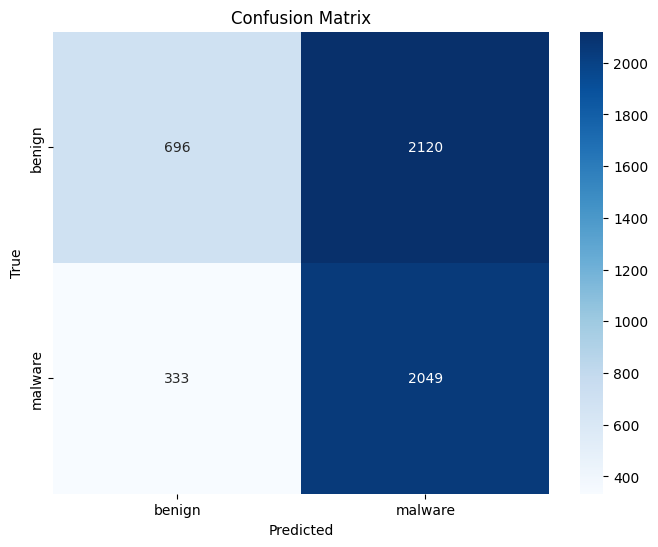

In [21]:
best_acc = 0.0
NUM_EPOCHS = 5
PATH = 'Bert(Devign).pth'  # 定义模型保存路径
for epoch in range(1, NUM_EPOCHS + 1):  # 3个epoch
    train(model, DEVICE, loader["train"], optimizer, epoch)
    acc, precision, recall, f1 = test(model, DEVICE, loader["val"])
    if best_acc < acc:
        best_acc = acc
        torch.save(model.state_dict(), PATH)  # 保存最优模型
    print("acc is: {:.4f}, best acc is {:.4f}n".format(acc, best_acc))

Test set: Average loss: 0.6692, Accuracy: 60.58%, Precision: 57.67%, Recall: 54.64%, F1: 56.11%


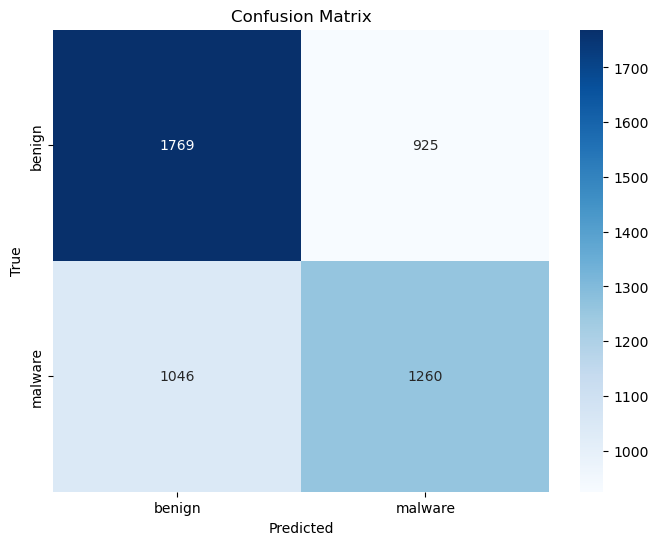

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_test = CodeBertClassifier().to("cuda")  # 替换为你的模型定义
model_test.load_state_dict(torch.load("Bert(Devign).pth"))  # 加载模型参数
# 测试模型
accuracy, precision, recall, f1 = test(model_test, device, loader['test'])